# Fake News Detection
**Name:** Daniel Mwaka

**Group:** Group 2B

## Introduction

## Data Loading and Preprocessing

### Data Loading

In [1]:
# Import basic libraries
import pandas as pd  
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt

# Import NLP tools and NLTK library modules
from collections import Counter
from wordcloud import WordCloud
import nltk 
from nltk.corpus import stopwords, wordnet 
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer 
from nltk import pos_tag  
import string  
import re 
#import spacy

# Import scikit-learn library's classes, tools, and modules 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import joblib

# Import tensorflow, and keras modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dropout, Dense, LSTM

# Import transformers and pytorch modules
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch


# Disable warnings
import warnings
warnings.filterwarnings('ignore')

2025-07-30 01:40:11.923118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753839611.945206      86 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753839611.952002      86 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# !pip install accelerate

In [3]:
data = pd.read_csv("/kaggle/input/data-csv/data.csv")
data.head()

,news_url,title,extracted_article_text,news_type,class
0,https://www.bustle.com/p/will-the-royals-retur...,Will 'The Royals' Return For Season 5? This St...,Entertainment With a royal wedding and a coup ...,gossip,1
1,https://www.foxnews.com/entertainment/naya-riv...,Naya Rivera refiles for divorce from Ryan Dors...,"This material may not be published, broadcast,...",gossip,1
2,https://www.unitedbypop.com/style/fashion/tayl...,Outfit ideas for Taylor Swift's Reputation Tour,United By Pop - United Kingdom. United States....,gossip,1
3,https://variety.com/2018/music/news/scott-hutc...,Scott Hutchison Dead: Frightened Rabbit Frontm...,By Robert Mitchell A body found Thursday night...,gossip,1
4,https://www.etonline.com/kate-middleton-gives-...,Kate Middleton Gives Birth to Royal Baby No. 3...,Baby No. 3 is officially here! Kate Middleton ...,gossip,1


In [4]:
# Check shape
data.shape

(16044, 5)

In [5]:
# Check duplicates
data.duplicated().sum()

928

In [6]:
# Drop duplicates
data.drop_duplicates(inplace=True)

In [7]:
# Confirm no duplicates
data.duplicated().sum()

0

In [8]:
# Inspect column attributes to check missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15116 entries, 0 to 16043
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   news_url                15116 non-null  object
 1   title                   15116 non-null  object
 2   extracted_article_text  15116 non-null  object
 3   news_type               15116 non-null  object
 4   class                   15116 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 708.6+ KB


- Data was successfully loaded and duplicates removed. 
- There are no entries with missing values

### Data Preprocessing

In [9]:
# Engineer the article feature
data['article'] = data['title'] + data['extracted_article_text']
data.head()

,news_url,title,extracted_article_text,news_type,class,article
0,https://www.bustle.com/p/will-the-royals-retur...,Will 'The Royals' Return For Season 5? This St...,Entertainment With a royal wedding and a coup ...,gossip,1,Will 'The Royals' Return For Season 5? This St...
1,https://www.foxnews.com/entertainment/naya-riv...,Naya Rivera refiles for divorce from Ryan Dors...,"This material may not be published, broadcast,...",gossip,1,Naya Rivera refiles for divorce from Ryan Dors...
2,https://www.unitedbypop.com/style/fashion/tayl...,Outfit ideas for Taylor Swift's Reputation Tour,United By Pop - United Kingdom. United States....,gossip,1,Outfit ideas for Taylor Swift's Reputation Tou...
3,https://variety.com/2018/music/news/scott-hutc...,Scott Hutchison Dead: Frightened Rabbit Frontm...,By Robert Mitchell A body found Thursday night...,gossip,1,Scott Hutchison Dead: Frightened Rabbit Frontm...
4,https://www.etonline.com/kate-middleton-gives-...,Kate Middleton Gives Birth to Royal Baby No. 3...,Baby No. 3 is officially here! Kate Middleton ...,gossip,1,Kate Middleton Gives Birth to Royal Baby No. 3...


- Define a function for **_text cleaning, normalization, word tokenizing, Part-of-Speech tagging, lemmatization_** and **_removing stopwords_**, using Regular Expressions (**re**), **NLTK**, and the **string** module. 

In [11]:
# nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [12]:
def clean_text(text):
    text = text.lower() # Lowercase all characters
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Drop URLs
    text = re.sub(r'\[.*?\]', '', text) # Remove content enclosed by []
    text = re.sub(r'<.*?>+', '', text) # Remove content enclosed with angle brackets
    text = re.sub(r'\n', ' ', text) # Replace newline characters with space to avoid merging words

    tokens = word_tokenize(text) # Tokenize the text into words
    tagged_tokens = pos_tag(tokens) # Apply POS tagging

    lemmatizer = WordNetLemmatizer() # Instantiate lemmatizer to reduce words to their base form

    # Define helper function to map NLTK's POS tags to WordNet's tags for lemmatization
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN # Default to noun if no clear mapping

    lemmatized_words = []
    for word, tag in tagged_tokens:
        wntag = get_wordnet_pos(tag)
        lemmatized_words.append(lemmatizer.lemmatize(word, wntag))

    stop_words = set(stopwords.words('english')) # Remove stopwords
    filtered_tokens_stopwords = [word for word in lemmatized_words if word not in stop_words]

    cleaned_tokens = [re.sub(r'[^a-zA-Z]', '', word) for word in filtered_tokens_stopwords] # Remove punctuation
    cleaned_tokens = [word for word in cleaned_tokens if word] # Remove empty strings that might result from cleaning 
    word_tokens = [word for word in cleaned_tokens if not word.isdigit()] # Remove digits
    final_tokens = [word for word in word_tokens if len(word) > 2] # Remove single-character and two-character words

    return final_tokens
# Apply the clean_text function to the 'article' column  
data['article'] = data['article'].apply(clean_text)

In [13]:
data.head()

,news_url,title,extracted_article_text,news_type,class,article
0,https://www.bustle.com/p/will-the-royals-retur...,Will 'The Royals' Return For Season 5? This St...,Entertainment With a royal wedding and a coup ...,gossip,1,"[the, royal, return, season, story, far, overe..."
1,https://www.foxnews.com/entertainment/naya-riv...,Naya Rivera refiles for divorce from Ryan Dors...,"This material may not be published, broadcast,...",gossip,1,"[naya, rivera, refiles, divorce, ryan, dorsey,..."
2,https://www.unitedbypop.com/style/fashion/tayl...,Outfit ideas for Taylor Swift's Reputation Tour,United By Pop - United Kingdom. United States....,gossip,1,"[outfit, idea, taylor, swift, reputation, tour..."
3,https://variety.com/2018/music/news/scott-hutc...,Scott Hutchison Dead: Frightened Rabbit Frontm...,By Robert Mitchell A body found Thursday night...,gossip,1,"[scott, hutchison, dead, frightened, rabbit, f..."
4,https://www.etonline.com/kate-middleton-gives-...,Kate Middleton Gives Birth to Royal Baby No. 3...,Baby No. 3 is officially here! Kate Middleton ...,gossip,1,"[kate, middleton, give, birth, royal, baby, bo..."


### Extraploratory Data Analysis

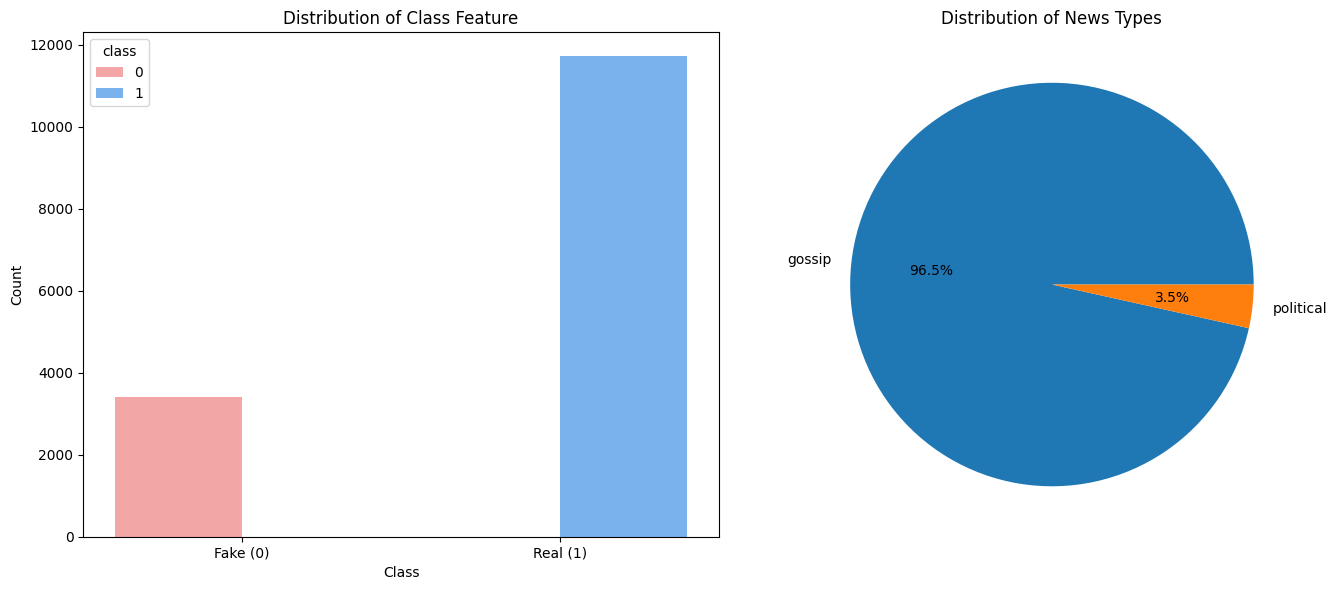

In [14]:
# Visualize Class Distribuction and News Type Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Bar plot for 'class' distribution 
sns.barplot(x='class', y='class', data=data, estimator=len, hue='class', palette=['#FF9999', '#66B2FF'], ax=axes[0])

# Add labels and title for the bar plot
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Class Feature')
axes[0].set_xticks([0, 1]) 
axes[0].set_xticklabels(['Fake (0)', 'Real (1)']) 

# Pie chart for 'news_type' distribution
news_type_counts = data['news_type'].value_counts()
axes[1].pie(news_type_counts, labels=news_type_counts.index, autopct='%1.1f%%')
axes[1].set_title('Distribution of News Types')
axes[1].set_ylabel('') 

plt.tight_layout()
plt.show()

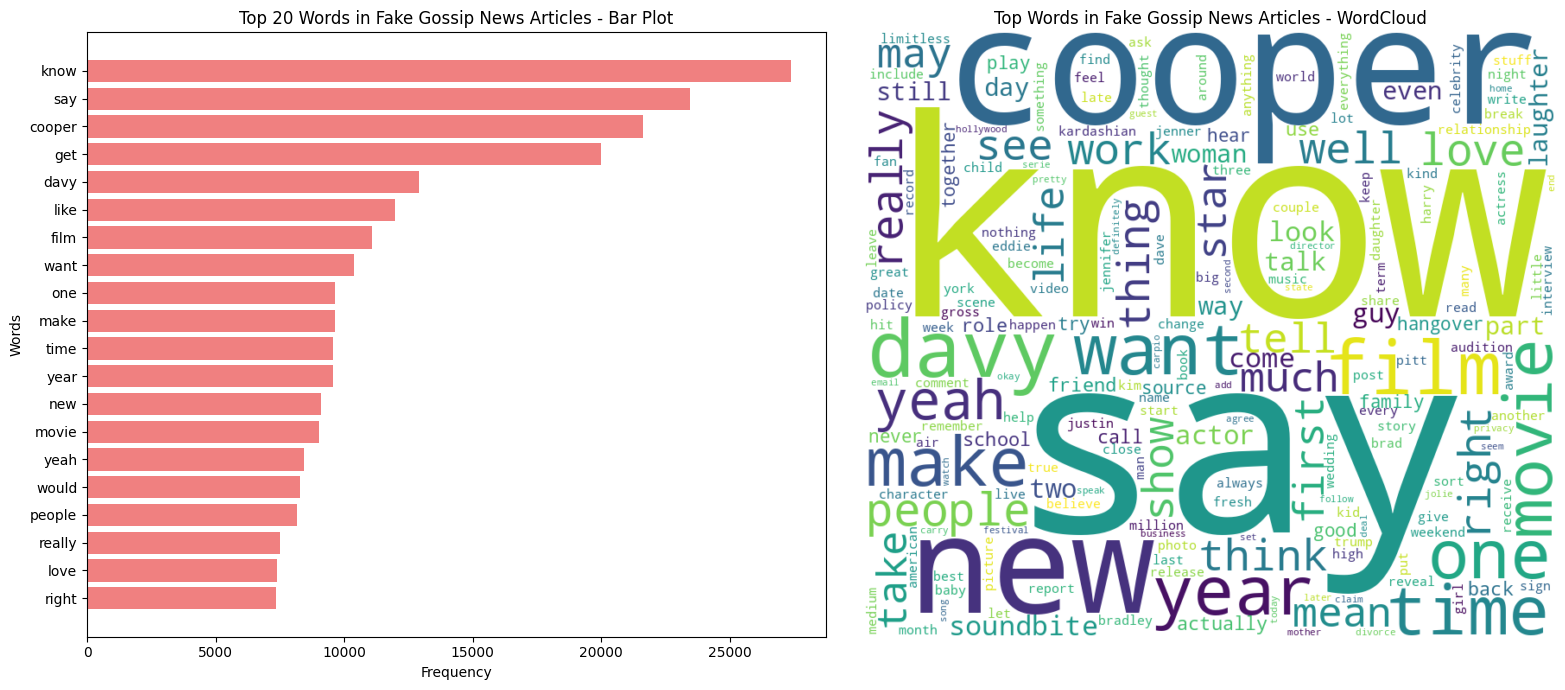

In [15]:
# Visualize the top 20 words in fake gossip news articles using a horizontal bar plot and a WordCloud
fake_gossip_news_df = data[(data['class'] == 0) & (data['news_type'] == 'gossip')]
all_fake_gossip_words = [word for sublist in fake_gossip_news_df['article'] for word in sublist]

# Count the frequency of each word
word_counts = Counter(all_fake_gossip_words)

# Get the top 20 most common words
top_20_words = word_counts.most_common(20)

# Prepare data for horizontal bar plot
words_for_plot = [item[0] for item in top_20_words]
counts_for_plot = [item[1] for item in top_20_words]

# Reverse the lists to plot highest count at the top in horizontal bar plot
words_for_plot.reverse()
counts_for_plot.reverse()

# Create a single string from the list of all fake gossip words for the WordCloud
text_for_wordcloud = " ".join(all_fake_gossip_words)

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=700,
                        background_color='white',
                        collocations=False # Set to False to avoid showing common bigrams as single words
                        ).generate(text_for_wordcloud)

# Create the plots
plt.figure(figsize=(16, 7)) 

# Subplot 1:Horizontal Bar Plot
plt.subplot(1, 2, 1) 
plt.barh(words_for_plot, counts_for_plot, color='lightcoral') 
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Words in Fake Gossip News Articles - Bar Plot')

# Subplot 2: WordCloud
plt.subplot(1, 2, 2) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 
plt.title('Top Words in Fake Gossip News Articles - WordCloud')
plt.tight_layout()
plt.show()

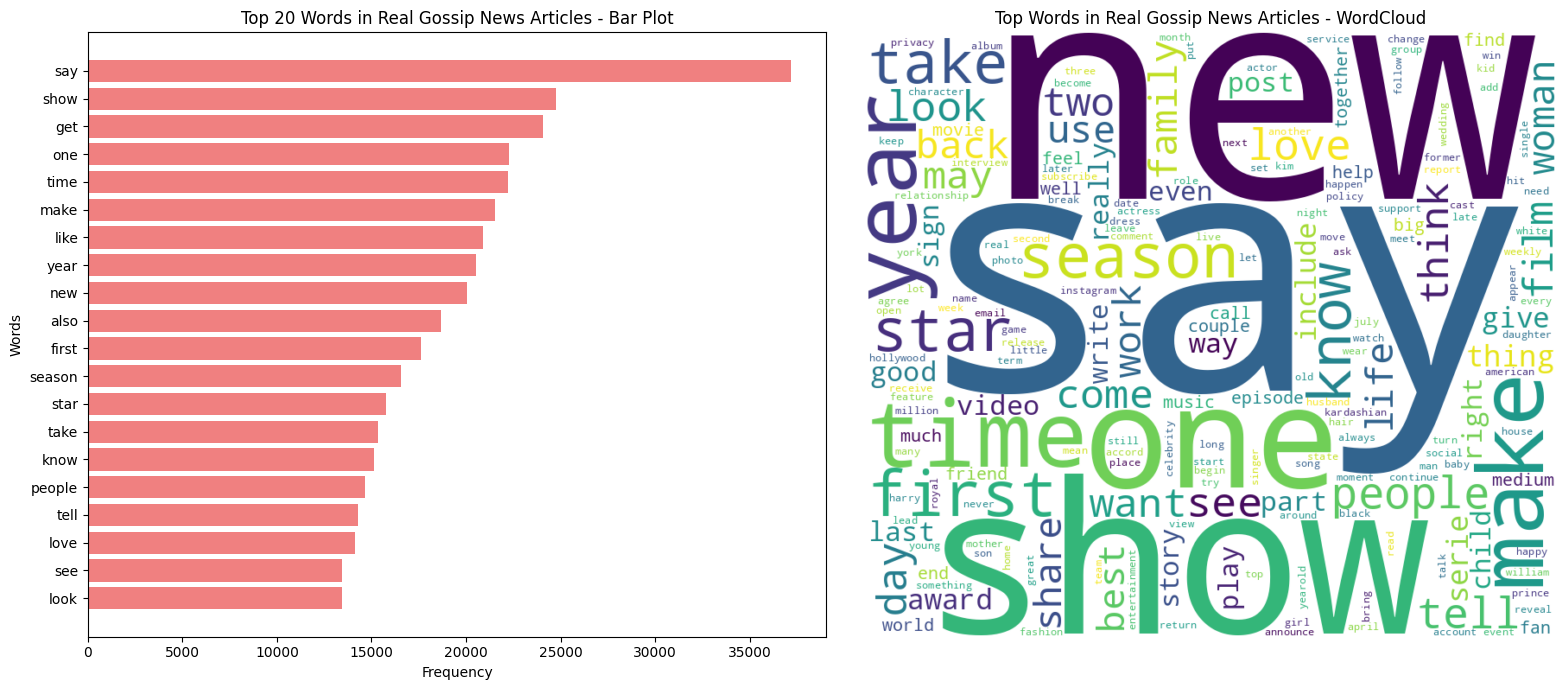

In [16]:
# Visualize the top 20 words in real gossip news articles using a horizontal bar plot and a WordCloud
real_gossip_news_df = data[(data['class'] == 1) & (data['news_type'] == 'gossip')]
all_real_gossip_words = [word for sublist in real_gossip_news_df['article'] for word in sublist]

# Count the frequency of each word
word_counts = Counter(all_real_gossip_words)

# Get the top 20 most common words
top_20_words = word_counts.most_common(20)

# Prepare data for horizontal bar plot
words_for_plot = [item[0] for item in top_20_words]
counts_for_plot = [item[1] for item in top_20_words]

# Reverse the lists to plot highest count at the top in horizontal bar plot
words_for_plot.reverse()
counts_for_plot.reverse()

# Create a single string from the list of all real gossip words for the WordCloud
text_for_wordcloud = " ".join(all_real_gossip_words)

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=700,
                        background_color='white',
                        collocations=False # Set to False to avoid showing common bigrams as single words
                        ).generate(text_for_wordcloud)

# Create the plots
plt.figure(figsize=(16, 7)) 

# Subplot 1:Horizontal Bar Plot
plt.subplot(1, 2, 1) 
plt.barh(words_for_plot, counts_for_plot, color='lightcoral') 
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Words in Real Gossip News Articles - Bar Plot')

# Subplot 2: WordCloud
plt.subplot(1, 2, 2) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 
plt.title('Top Words in Real Gossip News Articles - WordCloud')
plt.tight_layout()
plt.show()

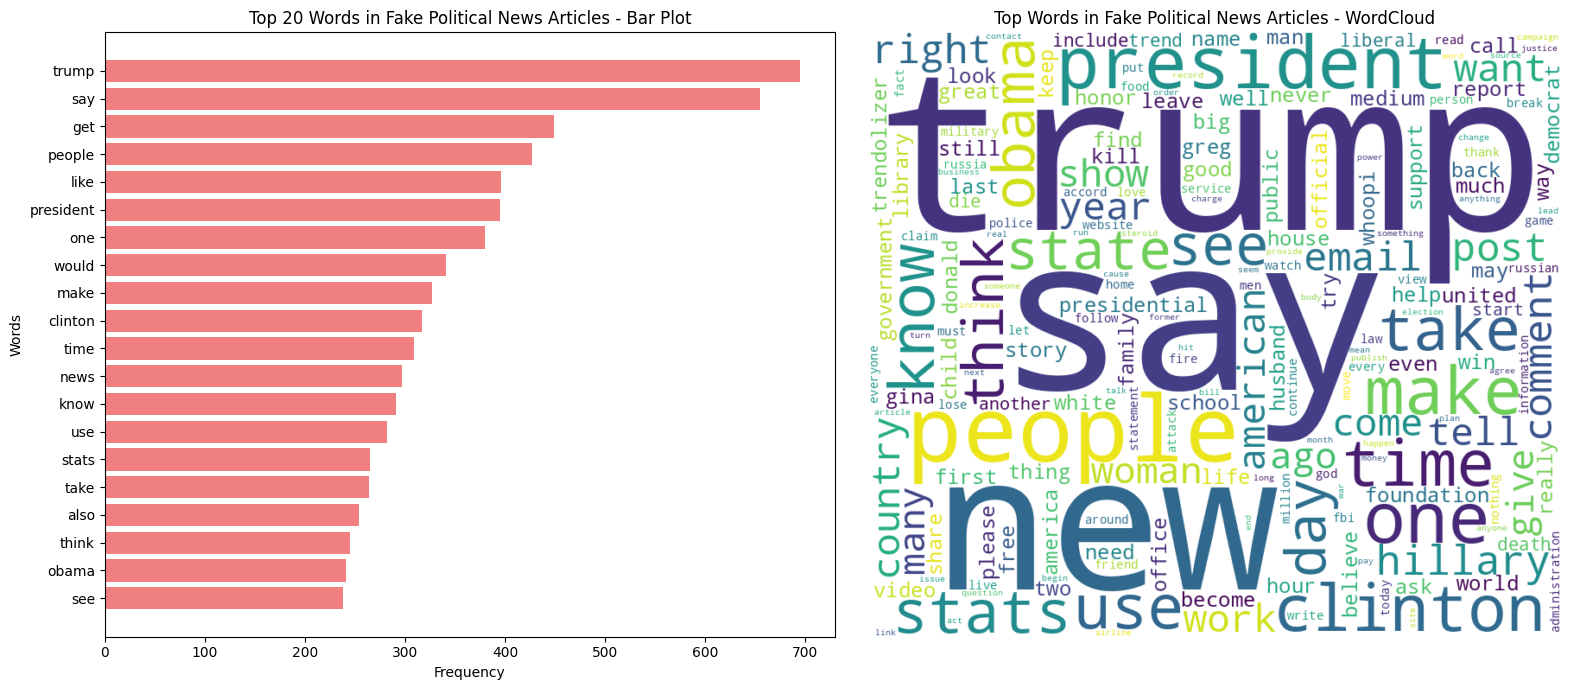

In [17]:
# Visualize the top 20 words in fake political news articles using a horizontal bar plot and a WordCloud
fake_political_news_df = data[(data['class'] == 0) & (data['news_type'] == 'political')]
all_fake_political_words = [word for sublist in fake_political_news_df['article'] for word in sublist]

# Count the frequency of each word
word_counts = Counter(all_fake_political_words)

# Get the top 20 most common words
top_20_words = word_counts.most_common(20)

# Prepare data for horizontal bar plot
words_for_plot = [item[0] for item in top_20_words]
counts_for_plot = [item[1] for item in top_20_words]

# Reverse the lists to plot highest count at the top in horizontal bar plot
words_for_plot.reverse()
counts_for_plot.reverse()

# Create a single string from the list of all fake political words for the WordCloud
text_for_wordcloud = " ".join(all_fake_political_words)

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=700,
                        background_color='white',
                        collocations=False # Set to False to avoid showing common bigrams as single words
                        ).generate(text_for_wordcloud)

# Create the plots
plt.figure(figsize=(16, 7)) 

# Subplot 1:Horizontal Bar Plot
plt.subplot(1, 2, 1) 
plt.barh(words_for_plot, counts_for_plot, color='lightcoral') 
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Words in Fake Political News Articles - Bar Plot')

# Subplot 2: WordCloud
plt.subplot(1, 2, 2) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 
plt.title('Top Words in Fake Political News Articles - WordCloud')
plt.tight_layout()
plt.show()

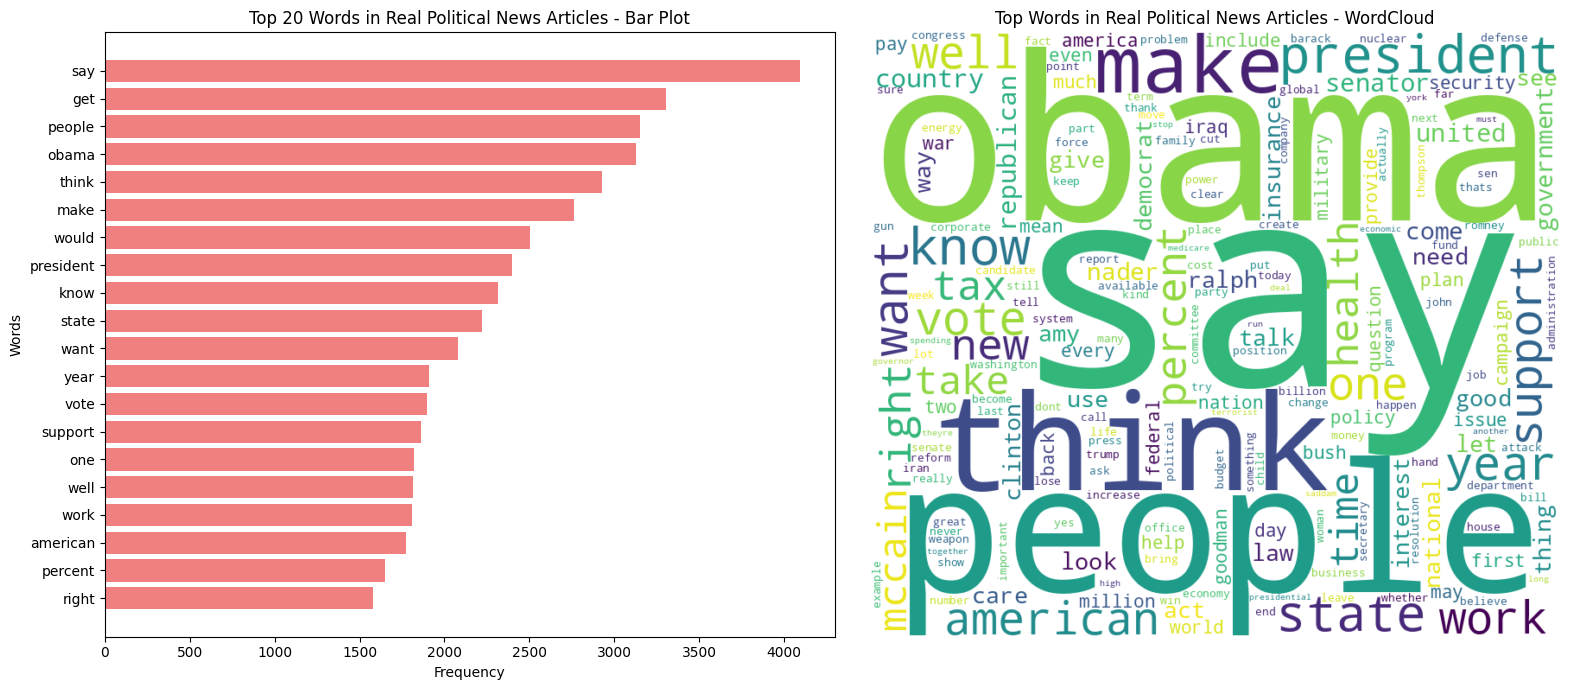

In [18]:
# Visualize the top 20 words in real political news articles using a horizontal bar plot and a WordCloud
real_political_news_df = data[(data['class'] == 1) & (data['news_type'] == 'political')]
all_real_political_words = [word for sublist in real_political_news_df['article'] for word in sublist]

# Count the frequency of each word
word_counts = Counter(all_real_political_words)

# Get the top 20 most common words
top_20_words = word_counts.most_common(20)

# Prepare data for horizontal bar plot
words_for_plot = [item[0] for item in top_20_words]
counts_for_plot = [item[1] for item in top_20_words]

# Reverse the lists to plot highest count at the top in horizontal bar plot
words_for_plot.reverse()
counts_for_plot.reverse()

# Create a single string from the list of all real political words for the WordCloud
text_for_wordcloud = " ".join(all_real_political_words)

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=700,
                        background_color='white',
                        collocations=False # Set to False to avoid showing common bigrams as single words
                        ).generate(text_for_wordcloud)

# Create the plots
plt.figure(figsize=(16, 7)) 

# Subplot 1:Horizontal Bar Plot
plt.subplot(1, 2, 1) 
plt.barh(words_for_plot, counts_for_plot, color='lightcoral') 
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Words in Real Political News Articles - Bar Plot')

# Subplot 2: WordCloud
plt.subplot(1, 2, 2) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 
plt.title('Top Words in Real Political News Articles - WordCloud')
plt.tight_layout()
plt.show()

## Modelling

### Objective 1: Build a Model to Predict The News Type of an Article 

- Build an tune a Logistic Regression model to predict `news_type`(whether a news article categorizes under **_gossip_** or **_political_**) based on `article` (an article's tokenized text).

In [19]:
# Create a copy of the DataFrame to avoid modifying the original data
df_logistic = data.copy()

# Join tokenized article text
df_logistic["joined_text"] = df_logistic["article"].apply(lambda x: " ".join(x))

# Define Exog and Endog
X_logistic = df_logistic["joined_text"]
y_logistic = df_logistic["news_type"]

# Split data
'''First split: Training_full_logistic (80% of X) and Test_logistic (20% of X)'''
X_train_full_logistic, X_test_logistic, y_train_full_logistic, y_test_logistic = train_test_split(
    X_logistic, y_logistic, test_size=0.2, random_state=42, stratify=y_logistic)

'''Second split: Training (80% of X_train_full_logistic) and Validation (20% of X_train_full_logistic)'''
X_train_logistic, X_val_logistic, y_train_logistic, y_val_logistic = train_test_split(
    X_train_full_logistic, y_train_full_logistic, test_size=0.2, random_state=42, stratify=y_train_full_logistic)
    
# Print the sizes of each set
print(f"Training set size: {len(X_train_logistic)}")
print(f"Validation set size: {len(X_val_logistic)}")
print(f"Test set size: {len(X_test_logistic)}")

Training set size: 9673
Validation set size: 2419
Test set size: 3024


- Assemble pipelines for modelling a Logistic Regression model fitted with TF-IDF vectorized data and Count vectorized data.

TF-IDF Vectorizer Results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2335
           1       0.96      0.30      0.45        84

    accuracy                           0.98      2419
   macro avg       0.97      0.65      0.72      2419
weighted avg       0.97      0.98      0.97      2419


Count Vectorizer Results:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2335
           1       0.92      0.71      0.81        84

    accuracy                           0.99      2419
   macro avg       0.96      0.86      0.90      2419
weighted avg       0.99      0.99      0.99      2419



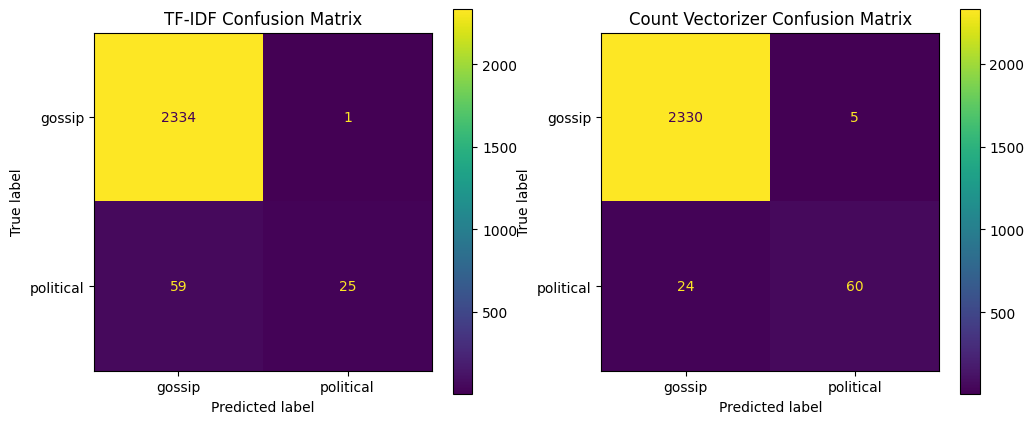

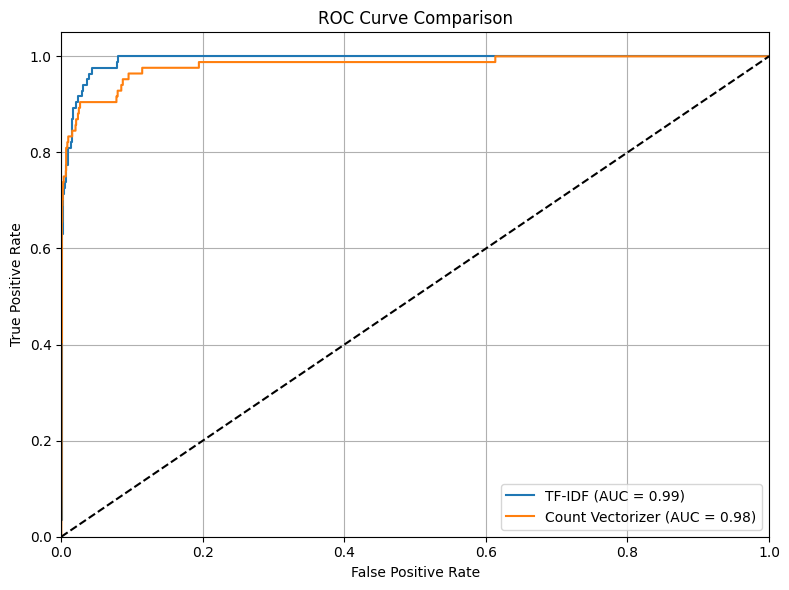

In [20]:
# Encode target labels
le = LabelEncoder()
y_train_logistic_encoded = le.fit_transform(y_train_logistic)
y_val_logistic_encoded = le.transform(y_val_logistic)

# Define pipelines
pipeline_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=200))
])

pipeline_count = Pipeline([
    ("count", CountVectorizer()),
    ("clf", LogisticRegression(max_iter=200))
])

# Fit pipelines
pipeline_tfidf.fit(X_train_logistic, y_train_logistic_encoded)
pipeline_count.fit(X_train_logistic, y_train_logistic_encoded)

# Get predictions and probabilities
y_pred_tfidf = pipeline_tfidf.predict(X_val_logistic)
y_pred_count = pipeline_count.predict(X_val_logistic)
y_prob_tfidf = pipeline_tfidf.predict_proba(X_val_logistic)[:, 1]
y_prob_count = pipeline_count.predict_proba(X_val_logistic)[:, 1]

# Print classification reports
print("TF-IDF Vectorizer Results:")
print(classification_report(y_val_logistic_encoded, y_pred_tfidf))
print("\nCount Vectorizer Results:")
print(classification_report(y_val_logistic_encoded, y_pred_count))

# Calculate ROC curves
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_val_logistic_encoded, y_prob_tfidf)
fpr_count, tpr_count, _ = roc_curve(y_val_logistic_encoded, y_prob_count)

# Calculate AUC
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)
roc_auc_count = auc(fpr_count, tpr_count)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# TF-IDF Confusion Matrix
cm_tfidf = confusion_matrix(y_val_logistic_encoded, y_pred_tfidf)
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=le.classes_)
disp_tfidf.plot(ax=ax1)
ax1.set_title('TF-IDF Confusion Matrix')

# Count Vectorizer Confusion Matrix
cm_count = confusion_matrix(y_val_logistic_encoded, y_pred_count)
disp_count = ConfusionMatrixDisplay(confusion_matrix=cm_count, display_labels=le.classes_)
disp_count.plot(ax=ax2)
ax2.set_title('Count Vectorizer Confusion Matrix')

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_tfidf, tpr_tfidf, label=f'TF-IDF (AUC = {roc_auc_tfidf:.2f})')
plt.plot(fpr_count, tpr_count, label=f'Count Vectorizer (AUC = {roc_auc_count:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

- Select Logistic Regression model fitted with vectorized data using CountVectorization to perform Hyperparameter tuning.

In [21]:
# Hyperparameter tuning with GridSearchCV()
# pipeline_count = Pipeline([
#     ("count", CountVectorizer()),
#     ("clf", LogisticRegression(max_iter=200))
# ])

# # Hyperparameter grid
# param_grid = {
#     "clf__C": [0.01, 0.1, 1, 10],
#     "clf__penalty": ["l2"],
#     "clf__solver": ["liblinear", "saga"]
# }

# # Run grid search
# grid_search_lr = GridSearchCV(pipeline_count, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search_lr.fit(X_train_product, y_train_product)

# # Best model and parameters
# print("Best Parameters:", grid_search_lr.best_params_)
# print("Best CV Score:", grid_search_lr.best_score_)

### Objective 2: Build a Baseline Model to Predict Class (Fake or Real) of an Article 
- Build an tune an XGBoost model to predict `class`[whether a news article categorizes under **_class 0_** (**Fake**) or **_class 1_** (**Real**)] based on `article` (an article's tokenized text).

In [22]:
# Create a copy of the DataFrame to avoid modifying the original data
df_xgb = data.copy()

# Join tokenized article text
df_xgb["joined_text"] = df_xgb["article"].apply(lambda x: " ".join(x))

# Define Exog and Endog
X_xgb = df_xgb["joined_text"]
y_xgb = df_xgb["class"]

# Split data
'''First split: Training_full_xgb (80% of X) and Test_xgb (20% of X)'''
X_train_full_xgb, X_test_xgb, y_train_full_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb)

'''Second split: Training (80% of X_train_full_xgb) and Validation (20% of X_train_full_xgb)'''
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train_full_xgb, y_train_full_xgb, test_size=0.2, random_state=42, stratify=y_train_full_xgb)

# Print the sizes of each set
print(f"Training set size: {len(X_train_xgb)}")
print(f"Validation set size: {len(X_val_xgb)}")
print(f"Test set size: {len(X_test_xgb)}")

Training set size: 9673
Validation set size: 2419
Test set size: 3024


XGBoost with TF-IDF Results:
              precision    recall  f1-score   support

           0       0.77      0.46      0.58       544
           1       0.86      0.96      0.91      1875

    accuracy                           0.85      2419
   macro avg       0.81      0.71      0.74      2419
weighted avg       0.84      0.85      0.83      2419


XGBoost with Count Vectorizer Results:
              precision    recall  f1-score   support

           0       0.79      0.46      0.58       544
           1       0.86      0.96      0.91      1875

    accuracy                           0.85      2419
   macro avg       0.83      0.71      0.75      2419
weighted avg       0.84      0.85      0.84      2419



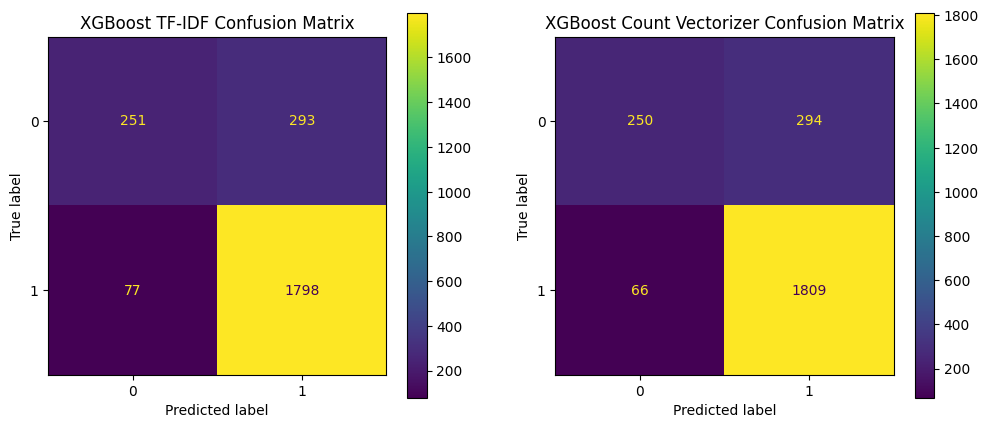

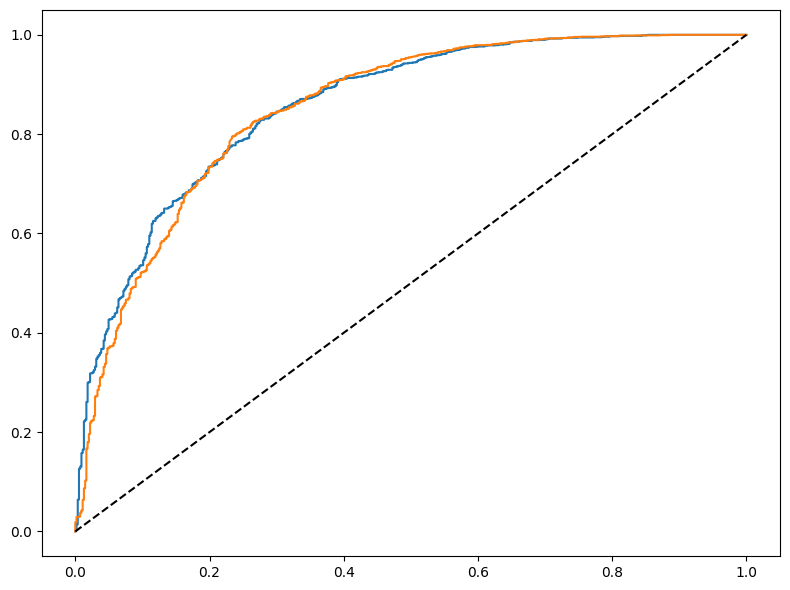

In [23]:
# Define pipelines 
pipeline_xgb_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

pipeline_xgb_count = Pipeline([
    ("count", CountVectorizer()),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Fit the pipelines
pipeline_xgb_tfidf.fit(X_train_xgb, y_train_xgb)
pipeline_xgb_count.fit(X_train_xgb, y_train_xgb)

# Get predictions and probabilities
y_pred_xgb_tfidf = pipeline_xgb_tfidf.predict(X_val_xgb)
y_prob_xgb_tfidf = pipeline_xgb_tfidf.predict_proba(X_val_xgb)[:, 1]
y_pred_xgb_count = pipeline_xgb_count.predict(X_val_xgb)
y_prob_xgb_count = pipeline_xgb_count.predict_proba(X_val_xgb)[:, 1]

# Print classification reports
print("XGBoost with TF-IDF Results:")
print(classification_report(y_val_xgb, y_pred_xgb_tfidf))
print("\nXGBoost with Count Vectorizer Results:")
print(classification_report(y_val_xgb, y_pred_xgb_count))

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# TF-IDF Confusion Matrix
cm_tfidf = confusion_matrix(y_val_xgb, y_pred_xgb_tfidf)
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf)
disp_tfidf.plot(ax=ax1)
ax1.set_title('XGBoost TF-IDF Confusion Matrix')

# Count Vectorizer Confusion Matrix
cm_count = confusion_matrix(y_val_xgb, y_pred_xgb_count)
disp_count = ConfusionMatrixDisplay(confusion_matrix=cm_count)
disp_count.plot(ax=ax2)
ax2.set_title('XGBoost Count Vectorizer Confusion Matrix')

# ROC curve data 
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_val_xgb, y_prob_xgb_tfidf)
fpr_count, tpr_count, _ = roc_curve(y_val_xgb, y_prob_xgb_count)

# AUC Scores
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)
roc_auc_count = auc(fpr_count, tpr_count)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_tfidf, tpr_tfidf, label=f'XGBoost TF-IDF (AUC = {roc_auc_tfidf:.2f})')
plt.plot(fpr_count, tpr_count, label=f'XGBoost Count (AUC = {roc_auc_count:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line

plt.tight_layout()
plt.show()

### Objective 3: Build an LSTM Neural Network to Predict Class (Fake or Real) of an Article 
- Build an tune a Long Short-Term Memory (**LSTM**) Neural Network model to predict `class`[whether a news article categorizes under **_class 0_** (**Fake**) or **_class 1_** (**Real**)] based on `article` (an article's tokenized text).

In [24]:
# Preprocessed Data
df_lstm = data.copy()
df_lstm["joined_text"] = df_lstm["article"].apply(lambda x: " ".join(x))
X_lstm = df_lstm["joined_text"]
y_lstm = df_lstm["class"]

# Data Split
X_train_full_lstm, X_test_lstm, y_train_full_lstm, y_test_full_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, random_state=42, stratify=y_lstm)

X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(
    X_train_full_lstm, y_train_full_lstm, test_size=0.2, random_state=42, stratify=y_train_full_lstm)

# Print the sizes of each set
print(f"Training set size: {len(X_train_lstm)}")
print(f"Validation set size: {len(X_val_lstm)}")
print(f"Test set size: {len(X_test_lstm)}")

Training set size: 9673
Validation set size: 2419
Test set size: 3024


Epoch 1/5


I0000 00:00:1753840592.105182      86 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753840592.106133      86 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1753840598.348427     145 cuda_dnn.cc:529] Loaded cuDNN version 90300


152/152 - 11s - 73ms/step - accuracy: 0.7733 - loss: 0.5606 - val_accuracy: 0.7780 - val_loss: 0.5291
Epoch 2/5
152/152 - 2s - 15ms/step - accuracy: 0.7907 - loss: 0.5034 - val_accuracy: 0.7813 - val_loss: 0.5075
Epoch 3/5
152/152 - 2s - 15ms/step - accuracy: 0.8297 - loss: 0.4248 - val_accuracy: 0.7652 - val_loss: 0.5391
Epoch 4/5
152/152 - 2s - 16ms/step - accuracy: 0.8494 - loss: 0.3771 - val_accuracy: 0.7797 - val_loss: 0.5959
Epoch 5/5
152/152 - 2s - 16ms/step - accuracy: 0.8513 - loss: 0.3665 - val_accuracy: 0.7722 - val_loss: 0.6308
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
LSTM Model Results:
              precision    recall  f1-score   support

           0       0.47      0.11      0.18       544
           1       0.79      0.96      0.87      1875

    accuracy                           0.77      2419
   macro avg       0.63      0.54      0.52      2419
weighted avg       0.72      0.77      0.71      2419



<Figure size 600x500 with 0 Axes>

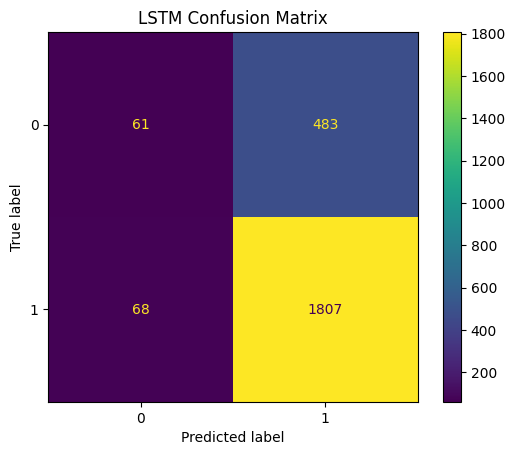

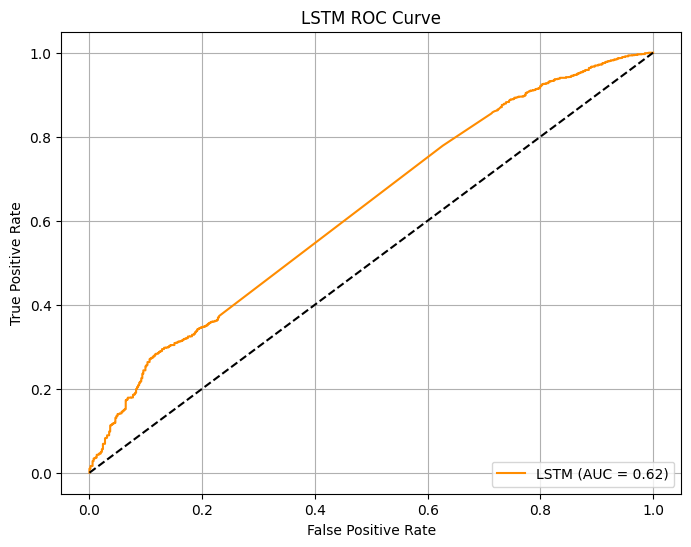

In [25]:
# Tokenization Parameters
vocab_size = 20000
max_length = 300
oov_tok = "<OOV>"

# Tokenize text
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_lstm)

X_train_seq = tokenizer.texts_to_sequences(X_train_lstm)
X_val_seq = tokenizer.texts_to_sequences(X_val_lstm)
X_test_seq = tokenizer.texts_to_sequences(X_test_lstm)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Convert labels to numpy arrays
y_train_arr = np.array(y_train_xgb)
y_val_arr = np.array(y_val_xgb)
y_test_arr = np.array(y_test_xgb)

# Build LSTM Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_pad, y_train_arr,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_pad, y_val_arr),
    verbose=2
)

# Predict on validation set
y_prob_lstm = model.predict(X_val_pad).ravel()
y_pred_lstm = (y_prob_lstm >= 0.5).astype(int)

# Classification Report
print("LSTM Model Results:")
print(classification_report(y_val_arr, y_pred_lstm))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm_lstm = confusion_matrix(y_val_arr, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm)
disp_lstm.plot()
plt.title('LSTM Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr_lstm, tpr_lstm, _ = roc_curve(y_val_arr, y_prob_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {roc_auc_lstm:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Objective 4: Leverage Transfer Learning to Pretrain the RoBERTa Transformer for Predicting Class (Fake or Real) of an Article 
- Pretrain the RoBERTa transformer to predict `class`[whether a news article categorizes under **_class 0_** (**Fake**) or **_class 1_** (**Real**)] based on `article` (an article's tokenized text).

In [26]:
# Preprocessed Data
df_roberta = data.copy()
df_roberta["joined_text"] = df_roberta["article"].apply(lambda x: " ".join(x))
X_roberta = df_roberta["joined_text"]
y_roberta = df_roberta["class"]

# Data Split
X_train_full_roberta, X_test_roberta, y_train_full_roberta, y_test_roberta = train_test_split(
    X_roberta, y_roberta, test_size=0.2, random_state=42, stratify=y_roberta)

X_train_roberta, X_val_roberta, y_train_roberta, y_val_roberta = train_test_split(
    X_train_full_roberta, y_train_full_roberta, test_size=0.2, random_state=42, stratify=y_train_full_roberta)

# Print the sizes of each set
print(f"Training set size: {len(X_train_roberta)}")
print(f"Validation set size: {len(X_val_roberta)}")
print(f"Test set size: {len(X_test_roberta)}")

Training set size: 9673
Validation set size: 2419
Test set size: 3024


In [ ]:
# Preprocessed Data
df_roberta = data.copy()
df_roberta["joined_text"] = df_roberta["article"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
X_roberta = df_roberta["joined_text"]
y_roberta = df_roberta["class"]

# Data Split
X_train_full_roberta, X_test_roberta, y_train_full_roberta, y_test_roberta = train_test_split(
    X_roberta, y_roberta, test_size=0.2, random_state=42, stratify=y_roberta)

X_train_roberta, X_val_roberta, y_train_roberta, y_val_roberta = train_test_split(
    X_train_full_roberta, y_train_full_roberta, test_size=0.2, random_state=42, stratify=y_train_full_roberta)

# Print the sizes of each set before undersampling
print(f"--- Sizes before Undersampling ---")
print(f"Training set size: {len(X_train_roberta)}")
print(f"Validation set size: {len(X_val_roberta)}")
print(f"Test set size: {len(X_test_roberta)}")
print(f"Class distribution in original training set (y_train_roberta):\n{y_train_roberta.value_counts()}")
print("-" * 40)

# Undersampling the Majority Class (1)
train_df = pd.DataFrame({'joined_text': X_train_roberta}).reset_index(drop=True)
train_df['target'] = y_train_roberta.reset_index(drop=True)
class_majority = train_df[train_df['target'] == 1]
class_minority = train_df[train_df['target'] == 0]
min_class_count = len(class_minority)

# Undersample the majority class
class_majority_undersampled = resample(class_majority,
                                       replace=False,    # Sample without replacement
                                       n_samples=min_class_count, # Match minority class size
                                       random_state=42) 
# Combine minority class with undersampled majority class
df_train_undersampled = pd.concat([class_majority_undersampled, class_minority])
df_train_undersampled = df_train_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Split back into features (X) and target (y)
X_train_roberta_undersampled = df_train_undersampled['joined_text']
y_train_roberta_undersampled = df_train_undersampled['target']

# Print the sizes and class distribution after undersampling
print(f"--- Sizes after Undersampling ---")
print(f"Undersampled training set size: {len(X_train_roberta_undersampled)}")
print(f"Class distribution in undersampled training set (y_train_roberta_undersampled):\n{y_train_roberta_undersampled.value_counts()}")
print("-" * 40)

# The validation and test sets remain unchanged
print(f"Validation set size (unchanged): {len(X_val_roberta)}")
print(f"Test set size (unchanged): {len(X_test_roberta)}")

### RoBERTa

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from datasets import Dataset
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from torch import cuda

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# Tokenize the datasets
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    probs = torch.softmax(torch.tensor(pred.predictions), dim=1)[:, 1].numpy()
    return {
        "accuracy": (preds == labels).mean(),
        "roc_auc": roc_auc_score(labels, probs),
        "f1": classification_report(labels, preds, output_dict=True)["weighted avg"]["f1-score"]
    }

# Custom callback for early stopping based on ROC AUC
class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=3):
        self.early_stopping_patience = early_stopping_patience
        self.best_roc_auc = -float("inf")
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        roc_auc = metrics.get("eval_roc_auc")
        if roc_auc > self.best_roc_auc:
            self.best_roc_auc = roc_auc
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.early_stopping_patience:
                control.should_training_stop = True

# Function to train and evaluate a RoBERTa model
def train_and_evaluate_roberta(train_X, train_y, val_X, val_y, test_X, test_y, model_tag):
    print(f"\n--- Training RoBERTa on {model_tag} Data ---")

    # Load a fresh model for each training run
    model = RobertaForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels=2,
        device_map="auto"
    )

    # Prepare Hugging Face datasets
    train_ds = Dataset.from_dict({"text": train_X.tolist(), "label": train_y.tolist()})
    val_ds = Dataset.from_dict({"text": val_X.tolist(), "label": val_y.tolist()})
    test_ds = Dataset.from_dict({"text": test_X.tolist(), "label": test_y.tolist()})

    # Tokenize datasets with batching
    train_tokenized = train_ds.map(tokenize_function, batched=True, remove_columns=["text"])
    val_tokenized = val_ds.map(tokenize_function, batched=True, remove_columns=["text"])
    test_tokenized = test_ds.map(tokenize_function, batched=True, remove_columns=["text"])

    # Set format for PyTorch
    train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    training_args = TrainingArguments(
        output_dir=f"./results_{model_tag}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        warmup_ratio=0.1,
        logging_dir=f'./logs_{model_tag}',
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="roc_auc",
        greater_is_better=True,
        fp16=cuda.is_available(),
        gradient_accumulation_steps=2,
        save_total_limit=2,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    # Save the fine-tuned model and tokenizer
    model.save_pretrained(f"/kaggle/working/fine_tuned_roberta_{model_tag}")
    tokenizer.save_pretrained(f"/kaggle/working/fine_tuned_roberta_{model_tag}")

    # Evaluate on validation set
    pred_val = trainer.predict(val_tokenized)
    preds_val = np.argmax(pred_val.predictions, axis=1)
    probs_val = torch.softmax(torch.tensor(pred_val.predictions), dim=1)[:, 1].numpy()

    print(f"\nRoBERTa Validation Results for {model_tag} Data:")
    print(classification_report(val_y, preds_val, digits=4))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(val_y, preds_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'RoBERTa Confusion Matrix - {model_tag} Data')
    plt.show()

    # ROC and AUC
    roc_auc = roc_auc_score(val_y, probs_val)
    print(f"ROC AUC for {model_tag} Data: {roc_auc:.4f}")
    fpr, tpr, _ = roc_curve(val_y, probs_val)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'RoBERTa {model_tag} (AUC = {roc_auc:.2f})', color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'RoBERTa ROC Curve - {model_tag} Data')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Evaluate on test set
    pred_test = trainer.predict(test_tokenized)
    preds_test = np.argmax(pred_test.predictions, axis=1)
    probs_test = torch.softmax(torch.tensor(pred_test.predictions), dim=1)[:, 1].numpy()

    print(f"\nRoBERTa Test Results for {model_tag} Data:")
    print(classification_report(test_y, preds_test, digits=4))
    print(f"Test ROC AUC for {model_tag} Data: {roc_auc_score(test_y, probs_test):.4f}")
    print("=" * 60)


# Run the pipeline for Imbalanced Data 
train_and_evaluate_roberta(X_train_roberta, y_train_roberta, X_val_roberta, y_val_roberta, X_test_roberta, y_test_roberta, "Imbalanced")

# Run the pipeline for Balanced Data 
train_and_evaluate_roberta(X_train_roberta_undersampled, y_train_roberta_undersampled, X_val_roberta, y_val_roberta, X_test_roberta, y_test_roberta, "Balanced")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9673 [00:00<?, ? examples/s]

Map:   0%|          | 0/2419 [00:00<?, ? examples/s]

Map:   0%|          | 0/3024 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc,F1
1,0.424400,0.376201,0.847044,0.851340,0.832265
2,0.360500,0.384048,0.847458,0.870412,0.841915
3,0.294000,0.357274,0.855726,0.876315,0.851330
4,0.265400,0.386558,0.849938,0.874593,0.847367
5,0.218600,0.420893,0.852418,0.872227,0.848402


RoBERTa Validation Results:
              precision    recall  f1-score   support

           0     0.7115    0.6029    0.6527       544
           1     0.8897    0.9291    0.9089      1875

    accuracy                         0.8557      2419
   macro avg     0.8006    0.7660    0.7808      2419
weighted avg     0.8496    0.8557    0.8513      2419



<Figure size 600x500 with 0 Axes>

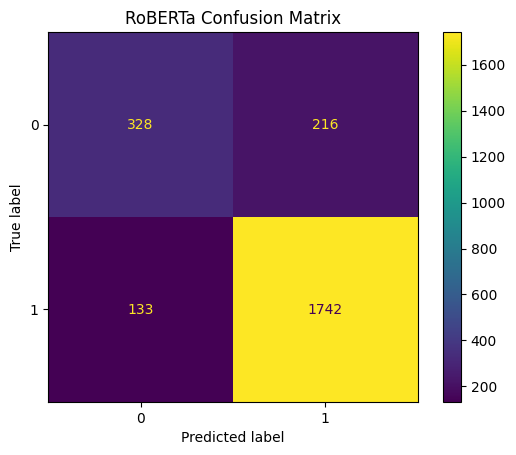

ROC AUC: 0.8763147058823528


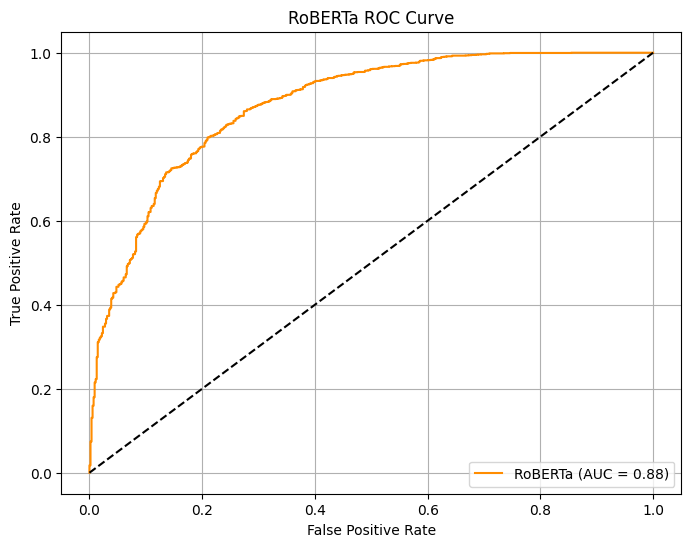

RoBERTa Test Results:
              precision    recall  f1-score   support

           0     0.7058    0.5926    0.6443       680
           1     0.8871    0.9283    0.9072      2344

    accuracy                         0.8528      3024
   macro avg     0.7964    0.7605    0.7758      3024
weighted avg     0.8463    0.8528    0.8481      3024

Test ROC AUC: 0.8647482307769524


In [30]:
# Finetune pretrained RoBERTa transformer on unbalanced dataset
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from datasets import Dataset
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from torch import cuda

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
    device_map="auto"  # Automatically place model on GPU if available
)

# Tokenize the datasets
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# Prepare Hugging Face datasets
train_ds = Dataset.from_dict({"text": X_train_roberta.tolist(), "label": y_train_roberta.tolist()})
val_ds = Dataset.from_dict({"text": X_val_roberta.tolist(), "label": y_val_roberta.tolist()})
test_ds = Dataset.from_dict({"text": X_test_roberta.tolist(), "label": y_test_roberta.tolist()})

# Tokenize datasets with batching
train_tokenized = train_ds.map(tokenize_function, batched=True, remove_columns=["text"])
val_tokenized = val_ds.map(tokenize_function, batched=True, remove_columns=["text"])
test_tokenized = test_ds.map(tokenize_function, batched=True, remove_columns=["text"])

# Set format for PyTorch
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    probs = torch.softmax(torch.tensor(pred.predictions), dim=1)[:, 1].numpy()
    return {
        "accuracy": (preds == labels).mean(),
        "roc_auc": roc_auc_score(labels, probs),
        "f1": classification_report(labels, preds, output_dict=True)["weighted avg"]["f1-score"]
    }

# Custom callback for early stopping based on ROC AUC
class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=3):
        self.early_stopping_patience = early_stopping_patience
        self.best_roc_auc = -float("inf")
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        roc_auc = metrics.get("eval_roc_auc")
        if roc_auc > self.best_roc_auc:
            self.best_roc_auc = roc_auc
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.early_stopping_patience:
                control.should_training_stop = True

# Define training arguments with best practices
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Increased to allow early stopping
    weight_decay=0.01,
    warmup_ratio=0.1,  # Warmup for 10% of training steps
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    greater_is_better=True,
    fp16=cuda.is_available(),  # Enable mixed precision training if GPU available
    gradient_accumulation_steps=2,  # Accumulate gradients for larger effective batch size
    save_total_limit=2,  # Keep only the 2 best checkpoints
    report_to="none"  # Disable wandb or other logging
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Fine-tune RoBERTa
trainer.train()

# Save the fine-tuned model and tokenizer
model.save_pretrained("/kaggle/working/fine_tuned_roberta")
tokenizer.save_pretrained("/kaggle/working/fine_tuned_roberta")

# Evaluate on validation set
pred_val = trainer.predict(val_tokenized)
preds_val = np.argmax(pred_val.predictions, axis=1)
probs_val = torch.softmax(torch.tensor(pred_val.predictions), dim=1)[:, 1].numpy()

# Print classification report and ROC AUC
print("RoBERTa Validation Results:")
print(classification_report(y_val_roberta, preds_val, digits=4))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm_roberta = confusion_matrix(y_val_roberta, preds_val)
disp_roberta = ConfusionMatrixDisplay(confusion_matrix=cm_roberta)
disp_roberta.plot()
plt.title('RoBERTa Confusion Matrix')
plt.show()

# ROC and AUC
print("ROC AUC:", roc_auc_score(y_val_roberta, probs_val))
fpr_roberta, tpr_roberta, _ = roc_curve(y_val_roberta, probs_val)
roc_auc_roberta = auc(fpr_roberta, tpr_roberta)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_roberta, tpr_roberta, label=f'RoBERTa (AUC = {roc_auc_roberta:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RoBERTa ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Evaluate on test set for completeness
pred_test = trainer.predict(test_tokenized)
preds_test = np.argmax(pred_test.predictions, axis=1)
probs_test = torch.softmax(torch.tensor(pred_test.predictions), dim=1)[:, 1].numpy()

print("RoBERTa Test Results:")
print(classification_report(y_test_roberta, preds_test, digits=4))
print("Test ROC AUC:", roc_auc_score(y_test_roberta, probs_test))

### BERT

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9673 [00:00<?, ? examples/s]

Map:   0%|          | 0/2419 [00:00<?, ? examples/s]

Map:   0%|          | 0/3024 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc,F1
1,0.433100,0.376074,0.845391,0.864213,0.821450
2,0.345400,0.340612,0.858206,0.885600,0.847928
3,0.260000,0.343946,0.860273,0.883157,0.856526
4,0.217700,0.414043,0.859859,0.879211,0.851966
5,0.135000,0.442190,0.850351,0.876681,0.847163


BERT Validation Results:
              precision    recall  f1-score   support

           0     0.7709    0.5257    0.6251       544
           1     0.8740    0.9547    0.9126      1875

    accuracy                         0.8582      2419
   macro avg     0.8225    0.7402    0.7689      2419
weighted avg     0.8508    0.8582    0.8479      2419



<Figure size 600x500 with 0 Axes>

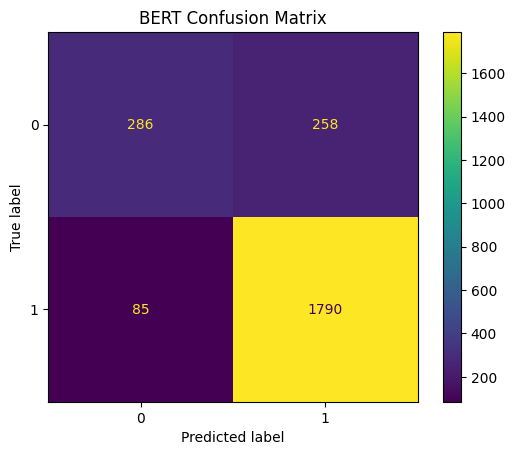

ROC AUC: 0.8855999999999999


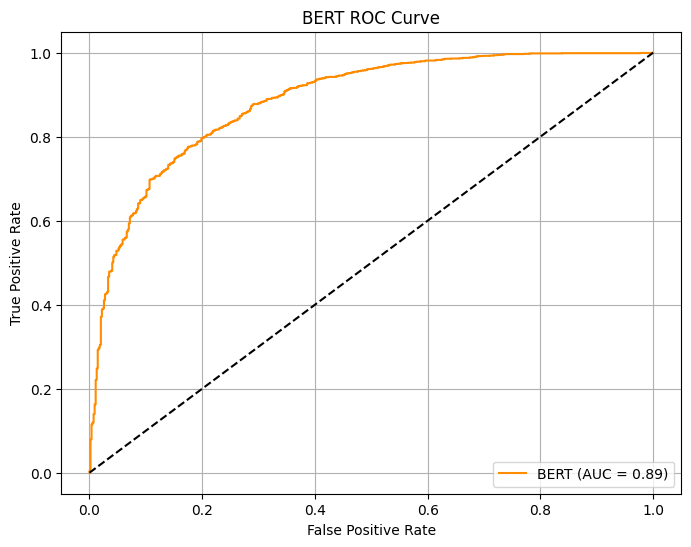

BERT Test Results:
              precision    recall  f1-score   support

           0     0.7746    0.5103    0.6152       680
           1     0.8707    0.9569    0.9118      2344

    accuracy                         0.8565      3024
   macro avg     0.8226    0.7336    0.7635      3024
weighted avg     0.8491    0.8565    0.8451      3024

Test ROC AUC: 0.8674538245332263


In [36]:
# Improved BERT
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from datasets import Dataset
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from torch import cuda

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    device_map="auto"  # Automatically place model on GPU if available
)

# Tokenize the datasets
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# Prepare Hugging Face datasets
train_ds = Dataset.from_dict({"text": X_train_roberta.tolist(), "label": y_train_roberta.tolist()})
val_ds = Dataset.from_dict({"text": X_val_roberta.tolist(), "label": y_val_roberta.tolist()})
test_ds = Dataset.from_dict({"text": X_test_roberta.tolist(), "label": y_test_roberta.tolist()})

# Tokenize datasets with batching
train_tokenized = train_ds.map(tokenize_function, batched=True, remove_columns=["text"])
val_tokenized = val_ds.map(tokenize_function, batched=True, remove_columns=["text"])
test_tokenized = test_ds.map(tokenize_function, batched=True, remove_columns=["text"])

# Set format for PyTorch
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    probs = torch.softmax(torch.tensor(pred.predictions), dim=1)[:, 1].numpy()
    return {
        "accuracy": (preds == labels).mean(),
        "roc_auc": roc_auc_score(labels, probs),
        "f1": classification_report(labels, preds, output_dict=True)["weighted avg"]["f1-score"]
    }

# Custom callback for early stopping based on ROC AUC
class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=3):
        self.early_stopping_patience = early_stopping_patience
        self.best_roc_auc = -float("inf")
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        roc_auc = metrics.get("eval_roc_auc")
        if roc_auc > self.best_roc_auc:
            self.best_roc_auc = roc_auc
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.early_stopping_patience:
                control.should_training_stop = True

# Define training arguments with best practices
training_args = TrainingArguments(
    output_dir="./results_bert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Increased to allow early stopping
    weight_decay=0.01,
    warmup_ratio=0.1,  # Warmup for 10% of training steps
    logging_dir='./logs_bert',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    greater_is_better=True,
    fp16=cuda.is_available(),  # Enable mixed precision training if GPU available
    gradient_accumulation_steps=2,  # Accumulate gradients for larger effective batch size
    save_total_limit=2,  # Keep only the 2 best checkpoints
    report_to="none"  # Disable wandb or other logging
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Fine-tune BERT
trainer.train()

# Save the fine-tuned model and tokenizer
model.save_pretrained("/kaggle/working/fine_tuned_bert")
tokenizer.save_pretrained("/kaggle/working/fine_tuned_bert")

# Evaluate on validation set
pred_val = trainer.predict(val_tokenized)
preds_val = np.argmax(pred_val.predictions, axis=1)
probs_val = torch.softmax(torch.tensor(pred_val.predictions), dim=1)[:, 1].numpy()

# Print classification report and ROC AUC
print("BERT Validation Results:")
print(classification_report(y_val_roberta, preds_val, digits=4))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm_bert = confusion_matrix(y_val_roberta, preds_val)
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert)
disp_bert.plot()
plt.title('BERT Confusion Matrix')
plt.show()

# ROC and AUC
print("ROC AUC:", roc_auc_score(y_val_roberta, probs_val))
fpr_bert, tpr_bert, _ = roc_curve(y_val_roberta, probs_val)
roc_auc_bert = auc(fpr_bert, tpr_bert)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERT ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Evaluate on test set for completeness
pred_test = trainer.predict(test_tokenized)
preds_test = np.argmax(pred_test.predictions, axis=1)
probs_test = torch.softmax(torch.tensor(pred_test.predictions), dim=1)[:, 1].numpy()

print("BERT Test Results:")
print(classification_report(y_test_roberta, preds_test, digits=4))
print("Test ROC AUC:", roc_auc_score(y_test_roberta, probs_test))

In [41]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    TrainerCallback
)
from datasets import Dataset
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import evaluate
import matplotlib.pyplot as plt
from torch import cuda

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if cuda.is_available() else "cpu")

# Load and prepare DataFrame for BERT
df_bert = data.copy()
df_bert["joined_text"] = df_bert["article"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
df_bert = df_bert[["joined_text", "class"]]
df_bert.rename(columns={"joined_text": "text", "class": "label"}, inplace=True)

# Train-validation-test split for BERT
train_val_df_bert, test_df_bert = train_test_split(
    df_bert, test_size=0.2, stratify=df_bert["label"], random_state=42
)
train_df_bert, val_df_bert = train_test_split(
    train_val_df_bert, test_size=0.2, stratify=train_val_df_bert["label"], random_state=42
)

print(f"\n--- BERT Data Sizes before Undersampling ---")
print(f"Training set size: {len(train_df_bert)}")
print(f"Validation set size: {len(val_df_bert)}")
print(f"Test set size: {len(test_df_bert)}")
print(f"Class distribution in original BERT training set:\n{train_df_bert['label'].value_counts()}")
print("-" * 40)

# Undersample Majority Class
train_df_bert_copy = train_df_bert.copy().reset_index(drop=True)
class_majority_bert = train_df_bert_copy[train_df_bert_copy['label'] == 1]
class_minority_bert = train_df_bert_copy[train_df_bert_copy['label'] == 0]
min_class_count_bert = len(class_minority_bert)
class_majority_undersampled_bert = resample(class_majority_bert,
                                          replace=False,
                                          n_samples=min_class_count_bert,
                                          random_state=42)

train_df_bert_undersampled = pd.concat([class_majority_undersampled_bert, class_minority_bert])
train_df_bert_undersampled = train_df_bert_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"--- BERT Data Sizes after Undersampling ---")
print(f"Undersampled training set size: {len(train_df_bert_undersampled)}")
print(f"Class distribution in undersampled training set:\n{train_df_bert_undersampled['label'].value_counts()}")
print("-" * 40)

# Load tokenizer for BERT
model_checkpoint_bert = "bert-base-uncased"
bert_tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint_bert)

# Tokenize the datasets for BERT
def tokenize_function_bert(examples):
    return bert_tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512, # BERT's typical max length
        return_tensors="pt"
    )

# Define evaluation metrics for BERT
bert_accuracy = evaluate.load("accuracy")

def compute_metrics_bert(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    return {
        "accuracy": bert_accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "roc_auc": roc_auc_score(labels, probs),
        "f1": classification_report(labels, preds, output_dict=True)["weighted avg"]["f1-score"]
    }

# Custom callback for early stopping based on ROC AUC
class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=3):
        self.early_stopping_patience = early_stopping_patience
        self.best_roc_auc = -float("inf")
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        roc_auc = metrics.get("eval_roc_auc")
        if roc_auc > self.best_roc_auc:
            self.best_roc_auc = roc_auc
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.early_stopping_patience:
                control.should_training_stop = True

# Function to train and evaluate a BERT model
def train_and_evaluate_bert(train_dataset_df, val_dataset_df, test_dataset_df, model_tag):
    print(f"\n--- Training BERT on {model_tag} Data ---")

    # Load a fresh model for each training run
    model = BertForSequenceClassification.from_pretrained(
        model_checkpoint_bert,
        num_labels=2,
        device_map="auto"
    )

    # Convert to Hugging Face Dataset
    train_ds_hf = Dataset.from_pandas(train_dataset_df.reset_index(drop=True))
    val_ds_hf = Dataset.from_pandas(val_dataset_df.reset_index(drop=True))
    test_ds_hf = Dataset.from_pandas(test_dataset_df.reset_index(drop=True))

    # Tokenize datasets with batching
    tokenized_train = train_ds_hf.map(tokenize_function_bert, batched=True, remove_columns=["text"])
    tokenized_val = val_ds_hf.map(tokenize_function_bert, batched=True, remove_columns=["text"])
    tokenized_test = test_ds_hf.map(tokenize_function_bert, batched=True, remove_columns=["text"])

    # Set format for PyTorch
    tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    training_args = TrainingArguments(
        output_dir=f"./bert-results-{model_tag}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        warmup_ratio=0.1,
        logging_dir=f"./logs_bert_{model_tag}",
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="roc_auc",
        greater_is_better=True,
        fp16=cuda.is_available(),
        gradient_accumulation_steps=2,
        save_total_limit=2,
        report_to="none"
    )

    data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=bert_tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_bert,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    model.save_pretrained(f"/kaggle/working/fine_tuned_bert_{model_tag}")
    bert_tokenizer.save_pretrained(f"/kaggle/working/fine_tuned_bert_{model_tag}")

    # Evaluate on validation set
    pred_val = trainer.predict(tokenized_val)
    preds_val = np.argmax(pred_val.predictions, axis=1)
    probs_val = torch.softmax(torch.tensor(pred_val.predictions), dim=1)[:, 1].numpy()

    print(f"\nBERT Validation Results for {model_tag} Data:")
    print(classification_report(val_dataset_df["label"], preds_val, digits=4))

    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(val_dataset_df["label"], preds_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'BERT Confusion Matrix - {model_tag} Data')
    plt.show()

    roc_auc = roc_auc_score(val_dataset_df["label"], probs_val)
    print(f"ROC AUC for {model_tag} Data: {roc_auc:.4f}")
    fpr, tpr, _ = roc_curve(val_dataset_df["label"], probs_val)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'BERT {model_tag} (AUC = {roc_auc:.2f})', color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'BERT ROC Curve - {model_tag} Data')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Evaluate on test set
    pred_test = trainer.predict(tokenized_test)
    preds_test = np.argmax(pred_test.predictions, axis=1)
    probs_test = torch.softmax(torch.tensor(pred_test.predictions), dim=1)[:, 1].numpy()

    print(f"\nBERT Test Results for {model_tag} Data:")
    print(classification_report(test_dataset_df["label"], preds_test, digits=4))
    print(f"Test ROC AUC for {model_tag} Data: {roc_auc_score(test_dataset_df['label'], probs_test):.4f}")
    print("=" * 60)

# Run the pipeline for BERT Imbalanced Data 
train_and_evaluate_bert(train_df_bert, val_df_bert, test_df_bert, "Imbalanced")

# Run the pipeline for BERT Balanced Data 
train_and_evaluate_bert(train_df_bert_undersampled, val_df_bert, test_df_bert, "Balanced")



--- BERT Data Sizes before Undersampling ---
Training set size: 9673
Validation set size: 2419
Test set size: 3024
Class distribution in original BERT training set:
label
1    7498
0    2175
Name: count, dtype: int64
----------------------------------------
--- BERT Data Sizes after Undersampling ---
Undersampled training set size: 4350
Class distribution in undersampled training set:
label
1    2175
0    2175
Name: count, dtype: int64
----------------------------------------

--- Training BERT on Imbalanced Data ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9673 [00:00<?, ? examples/s]

Map:   0%|          | 0/2419 [00:00<?, ? examples/s]

Map:   0%|          | 0/3024 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Longformer

In [33]:
# !pip install evaluate

In [40]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    TrainerCallback
)
from datasets import Dataset
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import evaluate
import matplotlib.pyplot as plt
from torch import cuda

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if cuda.is_available() else "cpu")

# Load and prepare DataFrame for Longformer
df_longformer = data.copy()
df_longformer["joined_text"] = df_longformer["article"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
df_longformer = df_longformer[["joined_text", "class"]]
df_longformer.rename(columns={"joined_text": "text", "class": "label"}, inplace=True)

# Train-validation-test split for Longformer
train_val_df_longformer, test_df_longformer = train_test_split(
    df_longformer, test_size=0.2, stratify=df_longformer["label"], random_state=42
)
train_df_longformer, val_df_longformer = train_test_split(
    train_val_df_longformer, test_size=0.2, stratify=train_val_df_longformer["label"], random_state=42
)

print(f"\n--- Longformer Data Sizes before Undersampling ---")
print(f"Training set size: {len(train_df_longformer)}")
print(f"Validation set size: {len(val_df_longformer)}")
print(f"Test set size: {len(test_df_longformer)}")
print(f"Class distribution in original Longformer training set:\n{train_df_longformer['label'].value_counts()}")
print("-" * 40)

# --- Undersampling the Majority Class (1) for Longformer ---

train_df_longformer_copy = train_df_longformer.copy().reset_index(drop=True)

class_majority_lf = train_df_longformer_copy[train_df_longformer_copy['label'] == 1]
class_minority_lf = train_df_longformer_copy[train_df_longformer_copy['label'] == 0]

min_class_count_lf = len(class_minority_lf)

class_majority_undersampled_lf = resample(class_majority_lf,
                                          replace=False,
                                          n_samples=min_class_count_lf,
                                          random_state=42)

train_df_longformer_undersampled = pd.concat([class_majority_undersampled_lf, class_minority_lf])
train_df_longformer_undersampled = train_df_longformer_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"--- Longformer Data Sizes after Undersampling ---")
print(f"Undersampled training set size: {len(train_df_longformer_undersampled)}")
print(f"Class distribution in undersampled training set:\n{train_df_longformer_undersampled['label'].value_counts()}")
print("-" * 40)

# Load tokenizer for Longformer
model_checkpoint_longformer = "allenai/longformer-base-4096"
longformer_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_longformer)

# Tokenize the datasets for Longformer
def tokenize_function_longformer(examples):
    return longformer_tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=1024,
        return_tensors="pt"
    )

# Define evaluation metrics for Longformer
longformer_accuracy = evaluate.load("accuracy")

def compute_metrics_longformer(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    return {
        "accuracy": longformer_accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "roc_auc": roc_auc_score(labels, probs),
        "f1": classification_report(labels, preds, output_dict=True)["weighted avg"]["f1-score"]
    }

# Custom callback for early stopping based on ROC AUC
class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=3):
        self.early_stopping_patience = early_stopping_patience
        self.best_roc_auc = -float("inf")
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        roc_auc = metrics.get("eval_roc_auc")
        if roc_auc > self.best_roc_auc:
            self.best_roc_auc = roc_auc
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.early_stopping_patience:
                control.should_training_stop = True

# Function to train and evaluate a Longformer model
def train_and_evaluate_longformer(train_dataset_df, val_dataset_df, test_dataset_df, model_tag):
    print(f"\n--- Training Longformer on {model_tag} Data ---")

    # Load a fresh model for each training run
    model = AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint_longformer,
        num_labels=2,
        device_map="auto"
    )

    # Convert to Hugging Face Dataset
    train_ds_hf = Dataset.from_pandas(train_dataset_df.reset_index(drop=True))
    val_ds_hf = Dataset.from_pandas(val_dataset_df.reset_index(drop=True))
    test_ds_hf = Dataset.from_pandas(test_dataset_df.reset_index(drop=True))

    # Tokenize datasets with batching
    tokenized_train = train_ds_hf.map(tokenize_function_longformer, batched=True, remove_columns=["text"])
    tokenized_val = val_ds_hf.map(tokenize_function_longformer, batched=True, remove_columns=["text"])
    tokenized_test = test_ds_hf.map(tokenize_function_longformer, batched=True, remove_columns=["text"])

    # Set format for PyTorch
    tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    training_args = TrainingArguments(
        output_dir=f"./longformer-results-{model_tag}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        num_train_epochs=5,
        weight_decay=0.01,
        warmup_ratio=0.1,
        logging_dir=f"./logs_longformer_{model_tag}",
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="roc_auc",
        greater_is_better=True,
        fp16=cuda.is_available(),
        gradient_accumulation_steps=4,
        save_total_limit=2,
        report_to="none"
    )

    data_collator = DataCollatorWithPadding(tokenizer=longformer_tokenizer)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=longformer_tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_longformer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    model.save_pretrained(f"/kaggle/working/fine_tuned_longformer_{model_tag}")
    longformer_tokenizer.save_pretrained(f"/kaggle/working/fine_tuned_longformer_{model_tag}")

    # Evaluate on validation set
    pred_val = trainer.predict(tokenized_val)
    preds_val = np.argmax(pred_val.predictions, axis=1)
    probs_val = torch.softmax(torch.tensor(pred_val.predictions), dim=1)[:, 1].numpy()

    print(f"\nLongformer Validation Results for {model_tag} Data:")
    print(classification_report(val_dataset_df["label"], preds_val, digits=4))

    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(val_dataset_df["label"], preds_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Longformer Confusion Matrix - {model_tag} Data')
    plt.show()

    roc_auc = roc_auc_score(val_dataset_df["label"], probs_val)
    print(f"ROC AUC for {model_tag} Data: {roc_auc:.4f}")
    fpr, tpr, _ = roc_curve(val_dataset_df["label"], probs_val)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Longformer {model_tag} (AUC = {roc_auc:.2f})', color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Longformer ROC Curve - {model_tag} Data')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Evaluate on test set
    pred_test = trainer.predict(tokenized_test)
    preds_test = np.argmax(pred_test.predictions, axis=1)
    probs_test = torch.softmax(torch.tensor(pred_test.predictions), dim=1)[:, 1].numpy()

    print(f"\nLongformer Test Results for {model_tag} Data:")
    print(classification_report(test_dataset_df["label"], preds_test, digits=4))
    print(f"Test ROC AUC for {model_tag} Data: {roc_auc_score(test_dataset_df['label'], probs_test):.4f}")
    print("=" * 60)

# Main execution calls for Longformer
# Run the pipeline for Longformer Imbalanced Data 
train_and_evaluate_longformer(train_df_longformer, val_df_longformer, test_df_longformer, "Imbalanced")

# Run the pipeline for Longformer Balanced Data
train_and_evaluate_longformer(train_df_longformer_undersampled, val_df_longformer, test_df_longformer, "Balanced")



--- Longformer Data Sizes before Undersampling ---
Training set size: 9673
Validation set size: 2419
Test set size: 3024
Class distribution in original Longformer training set:
label
1    7498
0    2175
Name: count, dtype: int64
----------------------------------------
--- Longformer Data Sizes after Undersampling ---
Undersampled training set size: 4350
Class distribution in undersampled training set:
label
1    2175
0    2175
Name: count, dtype: int64
----------------------------------------

--- Training Longformer on Imbalanced Data ---


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9673 [00:00<?, ? examples/s]

Map:   0%|          | 0/2419 [00:00<?, ? examples/s]

Map:   0%|          | 0/3024 [00:00<?, ? examples/s]

KeyboardInterrupt: 

## Evaluation

### Objective 5: Compare Respective Performance on test set to Determine Deployment Model

## Model Interpretability

## Deployment

## Conclusion and Recomendations

### Conclusion

### Recommendations

## Next Steps